In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection as ms
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [116]:
king = pd.read_csv('kc_house_data.csv')

In [117]:
king.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [118]:
king.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

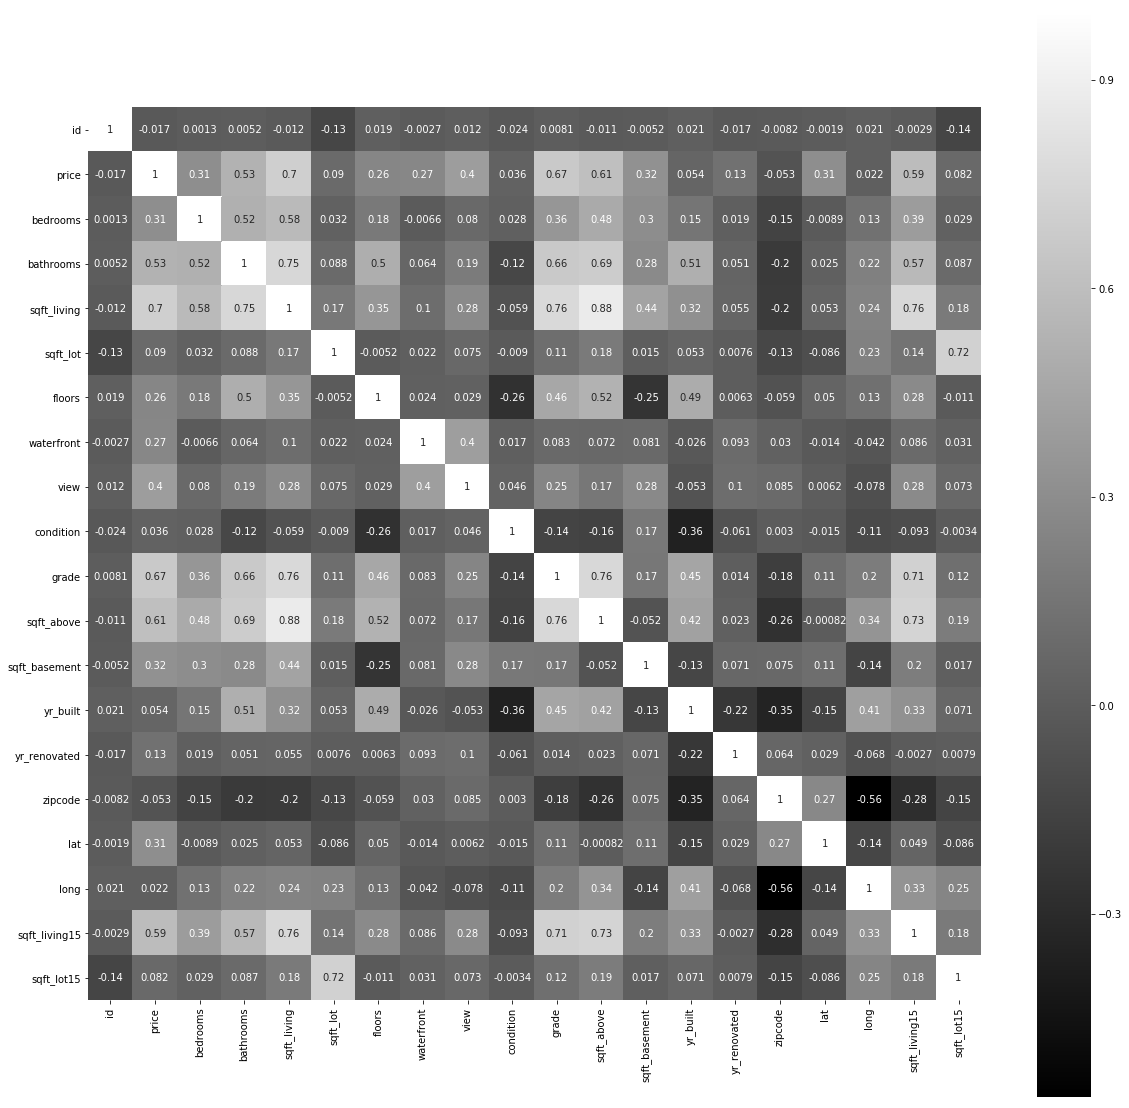

In [119]:
plt.figure(figsize=(20,20))
sns.heatmap(king.corr(), annot=True, square=True, cmap='gray')
plt.show()

- Select top features using correlation coeff and run a Linear Regression for it

In [120]:
top_feats = [i for i in king.columns if king[i].dtype!=np.object and king.corr()['price'][i]>0.2]

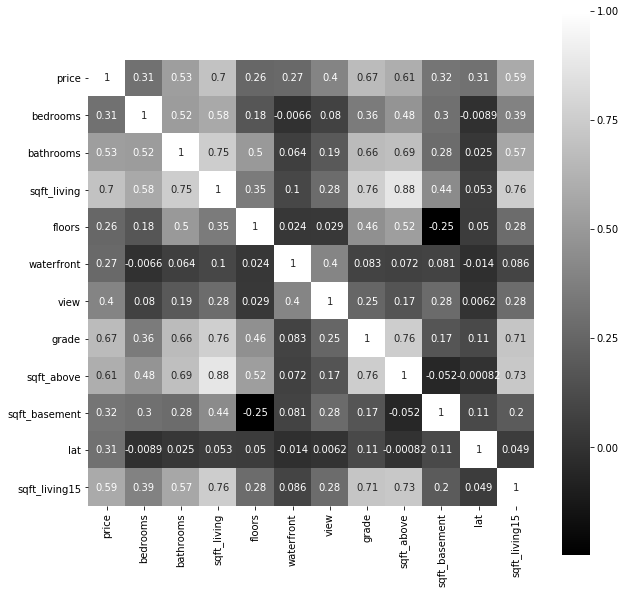

In [121]:
plt.figure(figsize=(10,10))
sns.heatmap(king[top_feats].corr(), annot=True, square=True, cmap='gray')
plt.show()

In [122]:
x_data = np.array(king[top_feats].drop('price', axis=1))
y_data = np.array(king['price'])
x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3, random_state=0)
linreg=LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
print(r2_score(y_test, y_pred))

0.6442095134602561


### Effect of feature addition and bias variance trade-off

In [123]:
top_feats = king.corr()[king.corr()['price']>0.2]['price'].sort_values(ascending=False).index

In [124]:
train_feats = []
corrbw = []
j=1
acc_mat, var_mat, r2ind_mat, slope_mat = [], [], [], []
for col in top_feats[1:]:
    train_feats.append(col)
    x_data = np.array(king[train_feats])
    y_data = np.array(king['price'])
    corrbw.append(king[[top_feats[j], top_feats[j-1]]].corr().iloc[0,1])
    r2_mat = []
    for i in range(5):
        x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3, random_state=i)
        linreg=LinearRegression()
        linreg.fit(x_train, y_train)
        y_pred = linreg.predict(x_test)
        r2_mat.append(r2_score(y_test, y_pred))
    acc_mat.append(np.mean(r2_mat))
    var_mat.append(np.var(r2_mat))
    
    x_data = np.array(king[[col]])
    y_data = np.array(king['price'])
    slope, r2_ind = [], []
    for i in range(5):
        x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3, random_state=i)
        scx = StandardScaler()
        x_train = scx.fit_transform(x_train)
        x_test = scx.transform(x_test)
        linreg=LinearRegression()
        linreg.fit(x_train, y_train)
        y_pred = linreg.predict(x_test)
        r2_ind.append(r2_score(y_test, y_pred))
        slope.append(linreg.coef_[0])
    r2ind_mat.append(np.mean(r2_ind))
    slope_mat.append(np.mean(slope))
    j+=1

In [125]:
bvt_linear = pd.DataFrame({'Added Feature' : train_feats, 'Corr with previous Feat' : corrbw, 'R2 Score (full model)' : acc_mat, 'Variance' : var_mat, 'R2-Ind feat' : r2ind_mat, 'Slope' : slope_mat})
bvt_linear

,Added Feature,Corr with previous Feat,R2 Score (full model),Variance,R2-Ind feat,Slope
0,sqft_living,0.702035,0.493571,0.000035,0.493571,255266.410245
1,grade,0.762704,0.534977,0.000018,0.446522,242687.947627
2,sqft_above,0.755923,0.540642,0.000017,0.370725,219680.971210
3,sqft_living15,0.731870,0.541520,0.000017,0.346552,212359.038378
4,bathrooms,0.568634,0.543896,0.000016,0.275628,190973.555706
5,view,0.187737,0.575651,0.000026,0.154555,144982.444794
6,sqft_basement,0.276947,0.575646,0.000026,0.101285,118515.368796
7,bedrooms,0.303093,0.580445,0.000023,0.096231,111702.524699
8,lat,-0.008931,0.635861,0.000023,0.089604,112989.869484
9,waterfront,-0.014274,0.654805,0.000073,0.074761,95490.971677


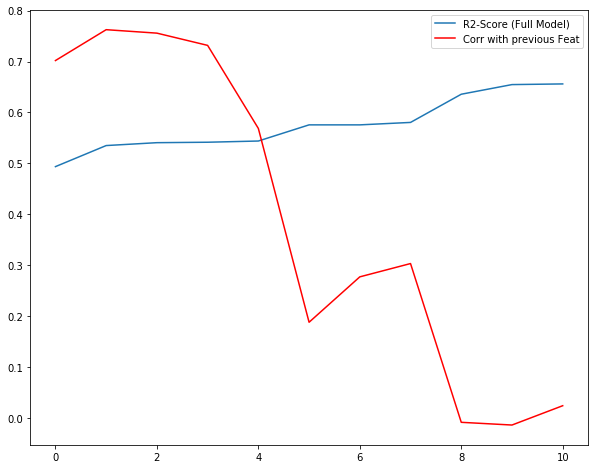

In [126]:
plt.figure(figsize=(10,8))
plt.plot(list(range(len(bvt_linear))), bvt_linear['R2 Score (full model)'])
plt.plot(list(range(len(bvt_linear))), bvt_linear['Corr with previous Feat'], color='r')
plt.legend(['R2-Score (Full Model)', 'Corr with previous Feat'])

- In the initial stage, there is strong correlation between features. Hence no significant improvement in R2-score.
- Once the inter-feature correlation drops sharply, the full model shows some increase.

## Linear Regression (All features)

In [127]:
lin_data = king.drop(['yr_built', 'yr_renovated', 'id', 'date'], axis=1)
# x_data = np.array(king[[i for i in king.columns if king[i].dtype!='object']].drop('price', axis=1))
top_feats = [i for i in king.columns if king[i].dtype!=np.object]
x_data = np.array(king[top_feats].drop('price', axis=1))
y_data = np.array(king['price'])
all_acc = []
for j in range(5):
    x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3, random_state=j)
    linreg=LinearRegression()
    linreg.fit(x_train, y_train)
    y_pred = linreg.predict(x_test)
    all_acc.append(r2_score(y_test, y_pred))
np.mean(all_acc)

0.6963230154819715

- 0.7 is a good place to start with, hoping that feature engineering may make some difference.
- It is always a good idea to repeat the fitting-predicting to check where the mean value R2-score falls
<br> <br>

## Polynomial degree 2 (All features)

In [128]:
from sklearn.preprocessing import PolynomialFeatures

In [129]:
king.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [138]:
top_feats = king.corr()['price'].sort_values(ascending=False).index
top_feats_new = [e for e in top_feats if e not in ['price', 'id', 'date']]
train_feats = []
corrbw = []
j=1
acc_mat, var_mat, r2ind_mat, slope_mat = [], [], [], []
for col in top_feats_new:
    train_feats.append(col)
    x_data = np.array(king[train_feats])
    y_data = np.array(king['price'])
    r2_mat = []
    for i in range(5):
        x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3)
        poly_feats = PolynomialFeatures(degree=2)
        x_train_d2 = poly_feats.fit_transform(x_train)
        x_test_d2 = poly_feats.transform(x_test)
        quadreg=LinearRegression()
        quadreg.fit(x_train_d2, y_train)
        y_pred = quadreg.predict(x_test_d2)
        r2_mat.append(r2_score(y_test, y_pred))
    acc_mat.append(np.mean(r2_mat))
    var_mat.append(np.var(r2_mat))

In [139]:
bvt_linear = pd.DataFrame({'Added Feature' : train_feats, 'R2 Score (full model)' : acc_mat})
bvt_linear

,Added Feature,R2 Score (full model)
0,sqft_living,0.537374
1,grade,0.590992
2,sqft_above,0.595859
3,sqft_living15,0.606762
4,bathrooms,0.612469
5,view,0.636403
6,sqft_basement,0.639580
7,bedrooms,0.625447
8,lat,0.682682
9,waterfront,0.729904


In [140]:
 x_data = np.array(king[train_feats])
y_data = np.array(king['price'])
r2_mat = []
for i in range(5):
    x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3)
    poly_feats = PolynomialFeatures(degree=2)
    x_train_d2 = poly_feats.fit_transform(x_train)
    x_test_d2 = poly_feats.transform(x_test)
    quadreg=LinearRegression()
    quadreg.fit(x_train_d2, y_train)
    y_pred = quadreg.predict(x_test_d2)
    r2_mat.append(r2_score(y_test, y_pred))
np.mean(r2_mat)

0.8113188547974628

- There is noticeable increase in R2-score with quadratic regression
- ~3.5% increase in R2-score is a good improvement in modeling

### k-Fold validationon Quadratic regressor (All features)

In [63]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [64]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
             'grade','yr_built','zipcode']
x_data = np.array(king[features])
y_data = np.array(king['price'])
x_data_d2 = poly_feats.fit_transform(x_data)

In [65]:
cv1 = float(format(cross_val_score(LinearRegression(), x_data_d2,y_data,cv=3).mean(),'.3f'))

In [66]:
cv1

0.716

## Feature Engineering

In [20]:
# estd is the column equal to age of the property from year built
king['estd'] = 2016 - king['yr_built'].apply(lambda x : int(x))

In [21]:
# check how many properties are no renovated at all
king[king['yr_renovated']==0].shape

(20699, 22)

In [22]:
# create a new column for years after renovation if any happened
king.loc[king['yr_renovated']!=0, 'renovated'] = 2016 - king.loc[king['yr_renovated']!=0, 'yr_renovated'].apply(lambda x : int(x))

In [23]:
king.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,estd,renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,61,NaN
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,65,25.0
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,83,NaN
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,51,NaN
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,29,NaN


<br> <br>
- Binning age (estd) - Use decision tree to optimize binning using entropy
<br>

In [24]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import pydotplus

In [25]:
dt_x = np.array(king[['estd']])
dt_y = np.array(king['price'])
dtree = DecisionTreeRegressor(max_depth=2)
dtree.fit(dt_x, dt_y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [26]:
king['estd_bins'] = pd.cut(king['estd'], bins=[0, 3.5, 25.5, 30, 200], labels=[1,2,3,4])
king.groupby('estd_bins')['price'].mean()

estd_bins
1    686011.996241
2    598750.906787
3    548506.897768
4    505171.238872
Name: price, dtype: float64

- Check the R2-score of a model built with the binned feature

In [27]:
x_data = np.array(king[['estd_bins']])
y_data = np.array(king['price'])
x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3, random_state=j)
linreg=LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
r2_score(y_test, y_pred)

0.015488577088766498

- Binning doesn't result in a variable good enough to represent the age variable

In [28]:
king.loc[king['renovated'].isnull(), 'renovated'] = king.loc[king['renovated'].isnull(), 'estd']
king['renovated_bins'] = pd.cut(king['renovated'], bins=[0, 25, 40, 200], labels=[1,2,3])
king.groupby('renovated_bins')['price'].mean()

renovated_bins
1    626854.391161
2    521762.611499
3    485417.575025
Name: price, dtype: float64

In [29]:
x_data = np.array(king[['renovated_bins']])
y_data = np.array(king['price'])
x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3, random_state=j)
linreg=LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
r2_score(y_test, y_pred)

0.02072246483383089

- Again, a weak feature, but it can be used if it gives a minute improvement in the final model, on test dataset (with cross validation)

### Latitude and Longitude

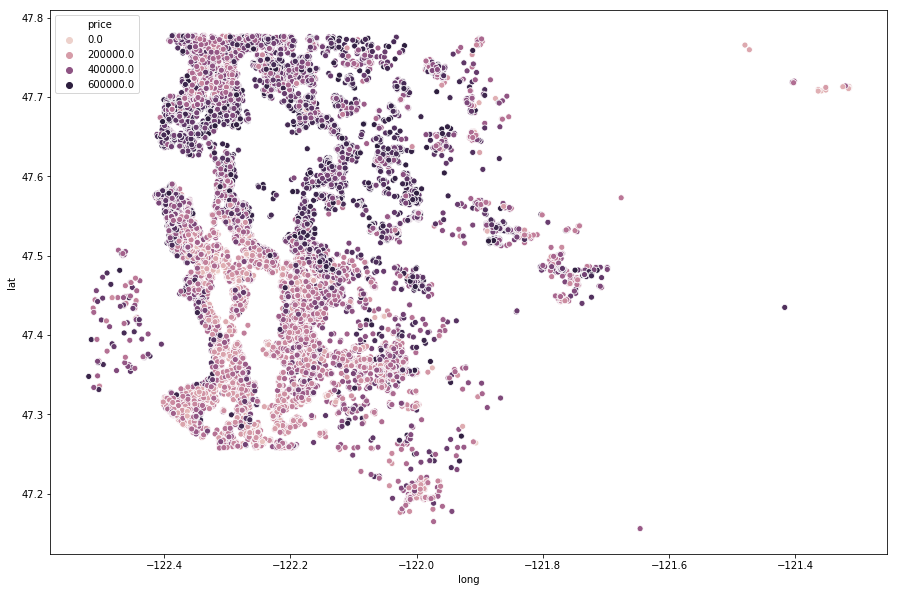

In [30]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='long', y='lat', hue='price', data=king[king['price']<600000])

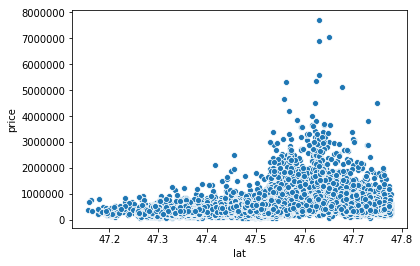

In [31]:
sns.scatterplot(x='lat', y='price', data=king)

In [32]:
king['lat_bins'] = pd.cut(king['lat'], bins=[47,47.4, 47.5, 47.6, 47.8], labels=[1,2,3,4])
king.groupby('lat_bins')['price'].mean()

lat_bins
1    309645.216216
2    361456.608956
3    599566.394613
4    650663.258790
Name: price, dtype: float64

In [33]:
x_data = np.array(king[['lat_bins']])
y_data = np.array(king['price'])
x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3, random_state=0)
linreg=LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
r2_score(y_test, y_pred)

0.13705087868944532

- Compared to the original lat feature, this is much better.
- Also this might make a good improvement in the final model

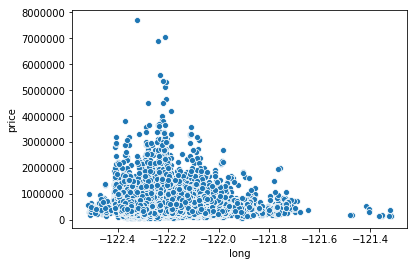

In [34]:
sns.scatterplot(x='long', y='price', data=king)

In [35]:
# king['long_bins'] = pd.cut(king['long'], bins=[-122.6, -122.4, -121.6, -121.2], labels=[1,2,3])
king['long_bins'] = 10
king.loc[((king['long']>-122.38) & (king['long']<-122.15)), 'long_bins'] = 1
king.loc[((king['long']<=-122.38) | (king['long']>=-122.15)), 'long_bins'] = 0
king.groupby('long_bins')['price'].mean()

long_bins
0    570622.997878
1    522097.273971
Name: price, dtype: float64

In [36]:
x_data = np.array(king[['long_bins']])
y_data = np.array(king['price'])
x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3, random_state=j)
linreg=LinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
r2_score(y_test, y_pred)

0.00284254345655921

- Longitude has s very weak correlation
- May not be useful at all in the final full model

In [37]:
king['estd_bins'] = pd.to_numeric(king['estd_bins'])
king['renovated_bins'] = pd.to_numeric(king['renovated_bins'])
king['lat_bins'] = pd.to_numeric(king['lat_bins'])
king['long_bins'] = pd.to_numeric(king['long_bins'])

## Running Linear Regression again

In [38]:
v2data = king.drop(['long_bins', 'yr_built', 'yr_renovated', 'id', 'date', 'lat', 'estd_bins', 'renovated_bins'], axis=1)

In [39]:
# Build a Linear regression model, replacing bad features with good binned fatures (latitude bins)
top_feats = [i for i in v2data.columns if v2data[i].dtype!=np.object]
x_data = np.array(v2data[top_feats].drop('price', axis=1))
y_data = np.array(v2data['price'])
all_acc = []
for j in range(5):
    x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3, random_state=j)
    linreg=LinearRegression()
    linreg.fit(x_train, y_train)
    y_pred = linreg.predict(x_test)
    all_acc.append(r2_score(y_test, y_pred))
np.mean(all_acc)

0.7132711287321987

- Adding binned latitude and removing some unwanted features made slight improvement in R2-score

## Polynomial Regression (All features, Degree=2)

In [40]:
from sklearn.preprocessing import PolynomialFeatures

In [141]:
# top_feats = 
x_data = np.array(v2data.drop('price', axis=1))
y_data = np.array(v2data['price'])
r2_mat = []
for i in range(5):
    x_train, x_test, y_train, y_test = ms.train_test_split(x_data, y_data, test_size=0.3)
    poly_feats = PolynomialFeatures(degree=2)
    x_train_d2 = poly_feats.fit_transform(x_train)
    x_test_d2 = poly_feats.transform(x_test)
    quadreg=LinearRegression()
    quadreg.fit(x_train_d2, y_train)
    y_pred = quadreg.predict(x_test_d2)
    r2_mat.append(r2_score(y_test, y_pred))
np.mean(r2_mat)

0.827988322207214